In [34]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [20]:
# Load dataset
df = pd.read_csv('daily_aggregated.csv')

In [36]:
# df.head(10)

In [23]:
# Exclusion and feature columns
EXCLUDE_COLS = ['date', 'daily_ridership', 'city', 'mode_train', 'mode_subway']
ALL_FEATURES = [col for col in df.columns if col not in EXCLUDE_COLS and pd.api.types.is_numeric_dtype(df[col])]

In [28]:
# Filter and transform data
df_model = df.dropna(subset=ALL_FEATURES + ['daily_ridership']).copy()
df_model['daily_ridership'] = np.log1p(df_model['daily_ridership'])  # log-transform target

# Log transform skewed inputs
LOG_FEATURES = ['rain_sum', 'rain_max', 'snowfall_sum', 'snowfall_max',
                'us_aqi_pm2_5_mean', 'us_aqi_pm10_mean', 'us_aqi_sulphur_dioxide_mean']
for col in LOG_FEATURES:
    if col in df_model.columns:
        df_model[col] = np.log1p(df_model[col])

X = df_model[ALL_FEATURES]
y = df_model['daily_ridership']

In [29]:
# Time series based split
# https://stackoverflow.com/questions/52138064/how-to-split-into-train-test-and-cv-in-an-non-reshuffle-order
# https://apxml.com/courses/time-series-analysis-forecasting/chapter-6-model-evaluation-selection/train-test-split-time-series
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [30]:
# Model training with time based grid search
pipeline = make_pipeline(StandardScaler(), Lasso(max_iter=10000))
param_grid = {'lasso__alpha': np.logspace(-4, 1, 50)}
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train) * 0.1))
grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=tscv)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

In [39]:
# Evaluation
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

r2 = r2_score(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("Lasso Regression (All Features)")
print(f"Best Alpha: {grid.best_params_['lasso__alpha']}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

Lasso Regression (All Features)
Best Alpha: 0.004291934260128779
R² Score: 0.2056
RMSE: 1186926.50
MAE : 755818.95


In [40]:
# Time based cv split
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train) * 0.1))

# cv scores (log transformed target)
r2_cv = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
rmse_cv = -cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
mae_cv = -cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

print("Lasso CV Performance (Log-Transformed Target, TimeSeriesSplit)")
print(f"R²        : {r2_cv.mean():.4f} ± {r2_cv.std():.4f}")
print(f"RMSE (log): {rmse_cv.mean():.4f} ± {rmse_cv.std():.4f}")
print(f"MAE  (log): {mae_cv.mean():.4f} ± {mae_cv.std():.4f}")

Lasso CV Performance (Log-Transformed Target, TimeSeriesSplit)
R²        : 0.4121 ± 0.0734
RMSE (log): 0.7350 ± 0.0349
MAE  (log): 0.5779 ± 0.0306


In [41]:
# # 8. Plot: Predictions vs. Actual
# plt.figure(figsize=(6, 6))
# sns.scatterplot(x=y_test_actual, y=y_pred_actual)
# plt.plot([y_test_actual.min(), y_test_actual.max()],
#          [y_test_actual.min(), y_test_actual.max()], 'r--')
# plt.xlabel("Actual Daily Ridership")
# plt.ylabel("Predicted Daily Ridership")
# plt.title("Lasso Regression: Prediction vs Actual")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

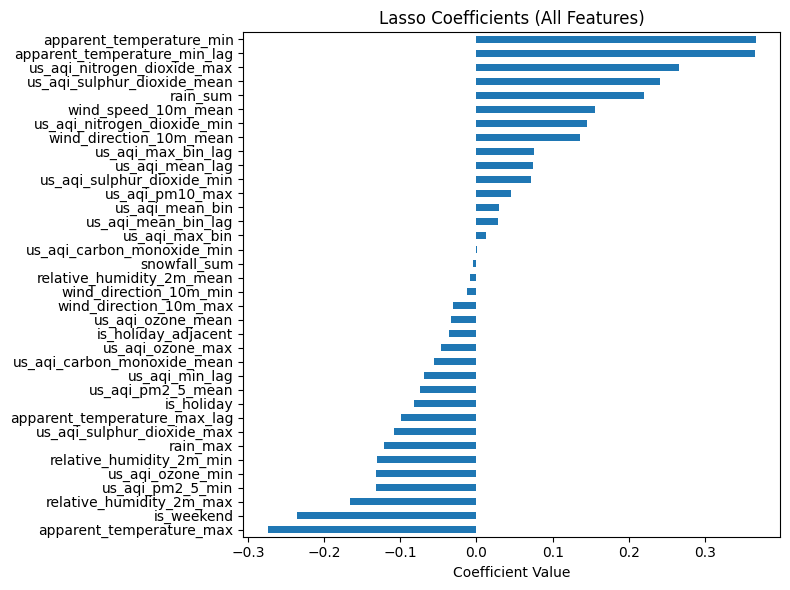

In [42]:
# 9. Plot: Nonzero Coefficients
lasso_model = best_model.named_steps['lasso']
coefs = pd.Series(lasso_model.coef_, index=ALL_FEATURES)
nonzero_coefs = coefs[coefs != 0].sort_values()

plt.figure(figsize=(8, 6))
nonzero_coefs.plot(kind='barh')
plt.title("Lasso Coefficients (All Features)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

Lasso Regression (Top 20 Features)
Best Alpha: 0.0001
R² Score: 0.2273
RMSE: 1120326.96


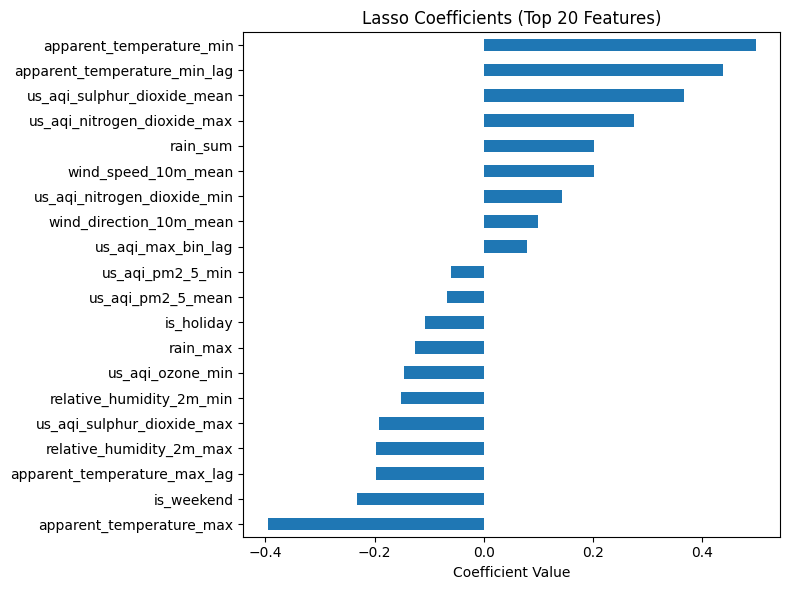

In [43]:
# Identify top 20 features by absolute coefficient
coefs = pd.Series(best_model.named_steps['lasso'].coef_, index=ALL_FEATURES)
top20_features = coefs.abs().sort_values(ascending=False).head(20).index.tolist()

# Subset training data to those features
X_top20 = df_model[top20_features]
y_top20 = df_model['daily_ridership']

# Train/test split
X_train20, X_test20, y_train20, y_test20 = train_test_split(X_top20, y_top20, random_state=42)

# Refit pipeline with top 20
pipeline_top20 = make_pipeline(StandardScaler(), Lasso(max_iter=10000))
param_grid_top20 = {'lasso__alpha': np.logspace(-4, 1, 50)}
grid_top20 = GridSearchCV(pipeline_top20, param_grid_top20, scoring='r2', cv=5)
grid_top20.fit(X_train20, y_train20)

# Evaluate performance
best_model20 = grid_top20.best_estimator_
y_pred20 = best_model20.predict(X_test20)

# Convert back from log scale
y_test_actual20 = np.expm1(y_test20)
y_pred_actual20 = np.expm1(y_pred20)

r2_20 = r2_score(y_test_actual20, y_pred_actual20)
rmse_20 = np.sqrt(mean_squared_error(y_test_actual20, y_pred_actual20))

print("Lasso Regression (Top 20 Features)")
print(f"Best Alpha: {grid_top20.best_params_['lasso__alpha']}")
print(f"R² Score: {r2_20:.4f}")
print(f"RMSE: {rmse_20:.2f}")

# Plot new coefficients
lasso_model20 = best_model20.named_steps['lasso']
coefs_top20 = pd.Series(lasso_model20.coef_, index=top20_features)

plt.figure(figsize=(8, 6))
coefs_top20.sort_values().plot(kind='barh')
plt.title("Lasso Coefficients (Top 20 Features)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()